In [16]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
import pyarrow
import numpy as np
import plotly.express as px
from tqdm import tqdm
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
import plotly.graph_objects as go

from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (24,20)
plt.rcParams['axes.facecolor'] = 'black'
sns.set_palette('Spectral')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# Split для временных рядов
def gain(value):
    if value < 0:
        return 0
    else:
        return value
    
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)
def TimeSeries_Split(ldf,
                     split_id=[None,None],
                     test_id=False,
                     cut_id=None):
    
    # Reduce the number of used data
    if(cut_id is not None):
        print('Reducing Input Data')
        
        if(type(cut_id) is int):
            ldf = ldf.iloc[-cut_id:]
        else:
            # input anything other than int
            print('Slicing based on period')
            ldf = ldf[data_period]
            
        t1 = ldf.index.max();t0 = ldf.index.min()
        print(f'Dataset Min.Index: {t0} | Max.Index: {t1}')
        
    if(split_id[0] is not None):
        # General Percentage Split (Non Shuffle requied for Time Series)
        train_df,pred_df = train_test_split(ldf,test_size=split_id[0],shuffle=False)
    elif(split_id[1] is not None):
        # specific time split 
        train_df = df.loc[:split_id[1]]; pred_df = df.loc[split_id[1]:] 
    else:
        print('Choose One Splitting Method Only')
        
#     y_train = train_df[feature]
#     X_train = train_df.loc[:, train_df.columns != feature]
#     if(test_id):
#         y_test = pred_df[feature]
#         X_test = pred_df.loc[:, pred_df.columns != feature]
        
    return train_df,pred_df # return 

#Работа с памятью, оптимизация памяти
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
#            print("******************************")
#            print("Column: ",col)
#            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
#            print("dtype after: ",df[col].dtype)
#            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

def create_alert_of_graf(df, batch=None, token=None):
    if batch!=None:
        scoring_signal_data = list(df[df['batch']==batch]['Time_alert'].unique())
        
        scoring_signal_price = list(df[df['batch']==batch]['Price_alert'].unique())
        
        index = df[df['batch']==batch][df[df['batch']==batch].Time.isin(scoring_signal_data)].index
        
        ret_df = pd.DataFrame(np.nan, index=df[df['batch']==batch].index, columns=[ 'Price_alert'])
    else:
        scoring_signal_data = pd.pivot_table(df[df['token']==token], 
                                             values='Time_alert', 
                                             index='batch', 
                                             aggfunc='max')['Time_alert'].values
        
        scoring_signal_price = pd.pivot_table(df[df['token']==token], 
                                             values='Price_alert', 
                                             index='batch', 
                                             aggfunc='max')['Price_alert'].values
        
        index = df[df['token']==token][df.Time.isin(scoring_signal_data)].drop_duplicates(subset=['Time']).index
        ret_df = pd.DataFrame(np.nan, index=df[df['token']==token].index, columns=['Price_alert'])
        
    count=0    
    for i in index:    
        ret_df.loc[i, ['Price_alert']] = [float(i) for i in scoring_signal_price][count]
        count+=1
    return ret_df

In [3]:
PATH = r'C:\Users\aleksandrovva1\Desktop\data science\crypto'
all_files = os.listdir(PATH)

In [65]:
df = []
court=0
for name in tqdm(all_files):
    dataframe = pd.read_csv(PATH+name)
    dataframe['batch'] = court
    df.append(dataframe)
    court+=1
df = pd.concat(df).reset_index()

100%|██████████████████████████████████████████████████████████████████████████████| 7346/7346 [01:38<00:00, 74.62it/s]


In [4]:
df = pd.read_parquet(PATH+'/all_df.pq')

In [64]:
df, miss_list = reduce_mem_usage(df)

Memory usage of properties dataframe is : 132.89809036254883  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  132.89809036254883  MB
This is  100.0 % of the initial size


In [ ]:
df[df['token']=='1000BONKUSDT']

In [65]:
df['Time'] = pd.to_datetime(df['Time'], unit='ms')
df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')
df['Time_alert'] = pd.to_datetime(df['Time_alert'], unit='ms')
df['Price_Change'] = df['Open']-df['Close']
df['min_max_range'] = df['High'] - df['Low']
df['meduim_price'] = np.mean([df['Open'],df['Close']], axis=0)
df['Price_Change'] = df['Open']-df['Close']
df['min_max_range'] = df['High'] - df['Low']
df['meduim_price'] = np.mean([df['Open'],df['Close']], axis=0)
#df = df.drop(['Volume_change'], axis=1)

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(df[df['batch']==0]['Time'], df[df['batch']==0]['Open'], c='g')
plt.plot(df[df['batch']==0]['Time'], df[df['batch']==0]['Close'], c='r')
plt.plot(df[df['batch']==0]['Time'], df[df['batch']==0]['Price_alert'], c='w')
plt.plot(df[df['batch']==0]['Time'], df[df['batch']==0]['meduim_price'], c='yellow')
plt.scatter(df[df['batch']==0]['Time_alert'], df[df['batch']==0]['Price_alert'], c='w')
#plt.hist(df[df['batch']==0]['Time'], df[df['batch']==0]['Number of trades'], c='b')
plt.show()

In [ ]:
for i in range(0,40):
    plt.figure(figsize=(18,6))
    plt.plot(df[df['batch']==i]['Time'], df[df['batch']==i]['meduim_price'], c='g')
#    plt.plot(df[df['batch']==i]['Time'], df[df['batch']==i]['Price_Change'], c='r')
    plt.plot(df[df['batch']==i]['Time'], df[df['batch']==i]['Price_alert'], c='r')
    plt.scatter(df[df['batch']==i]['Time_alert'], df[df['batch']==i]['Price_alert'], c='w')
    plt.legend()
    plt.show()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990766 entries, 0 to 1990765
Data columns (total 17 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   Time                         datetime64[ns]
 1   Open                         float32       
 2   High                         float32       
 3   Low                          float32       
 4   Close                        float32       
 5   Volume                       float32       
 6   Close time                   datetime64[ns]
 7   Quote asset volume           float32       
 8   Number of trades             uint32        
 9   Taker buy base asset volume  float32       
 10  Time_alert                   datetime64[ns]
 11  Price_alert                  float32       
 12  batch                        uint16        
 13  token                        object        
 14  Price_Change                 float32       
 15  min_max_range                float32       
 16  

In [ ]:
for i in range(0,10):
    signal = create_alert_of_graf(df, batch=i)
    mpf.plot(df[df['batch']==i].set_index('Close time'), 
            type='candle', style='charles',  
            volume=True,
            title=f" История по патерну крипты {df[df['batch']==i]['token'].unique()[0]}", 
            mav=(10,20,30),
            addplot=[
                mpf.make_addplot(signal, type='scatter',markersize=10, color='b', panel=0)
            ])
    plt.show()

In [396]:
# Цена имеет свойств сильно менят направляение при пересечении скользящих средних, также можно сделать предположение, что
# появление аллерта обусловленно положительным значением объема по крайней мере по токену 1000BONKUSDT, но графике видно, что
# что по объему пересечения и средних и обхемов есть и другие области действия, однако других аллертов не последовало, это говорит о том, что 
# информация требует дополнения

In [ ]:
for k in df['token'].unique():
    try_df = df[df['token']==k]
    signal = create_alert_of_graf(try_df, token=k)
    mpf.plot(try_df.set_index('Time'), 
                type='candle', style='charles',  
                volume=True,
                title=f" История по патерну крипты {try_df['token'].unique()[0]}", 
                mav=(10,20,30),
                addplot=[
                    mpf.make_addplot(signal, type='scatter',markersize=10, color='b', panel=0)
                ])

In [395]:
# в целом структура данных говорит о том, что данные представлют собой отдельные промежутки с конкретными алертами, следовательно 
# следовательно эти данные нельзя использовать в общем для построения временного ряда без дополнительного дополнения инормации с биржи#
# Также при быстром осмотре можно заметить, что аллерты происходят тогда, когда появляются объемы сделок по валюте

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [9]:
features = ['Open','High','Low','Close','Volume','Quote asset volume','Number of trades','Taker buy base asset volume']

In [10]:
log_df = np.log(df[df['batch']==0]['meduim_price'])

In [11]:
y_diff = df['meduim_price'].diff()

In [12]:
y_diff

0               NaN
1         -0.000017
2         -0.000004
3          0.000009
4          0.000023
             ...   
1990761   -0.000500
1990762   -0.001300
1990763    0.001200
1990764    0.002800
1990765    0.000100
Name: meduim_price, Length: 1990766, dtype: float32

In [13]:
log_df

0     -3.563199
1     -3.563816
2     -3.563975
3     -3.563658
4     -3.562864
         ...   
266   -3.542721
267   -3.542686
268   -3.542461
269   -3.542617
270   -3.542634
Name: meduim_price, Length: 271, dtype: float32

In [363]:
adfuller(log_df)

(-2.180899996147885,
 0.21325053982678255,
 10,
 260,
 {'1%': -3.4557539868570775,
  '5%': -2.8727214497041422,
  '10%': -2.572728476331361},
 -2805.7263182149172)

In [ ]:
features = [i for i in df.select_dtypes(np.number).columns if i not in ['batch']]
for i in df['token'].unique()[:20]:
    mask = np.triu(np.ones_like(df[df['token']==i][features].corr()))
    plt.figure(figsize=(18,12))
    plt.title(f'Корреляция признаков по токену: {i}')
    sns.heatmap(df[df['token']==i][features].corr(), annot=True, mask=mask, cmap='crest')
    plt.show()

In [14]:
# в целом видно, что по каждой валюте корреляция между ценой открытия/закрытия и Volume, Quote asset volume, Quote asset volume
# Number of trades отличаются, что может говорить о том, что нет такого торгового параметра, по которомк можно определить 
# движение цены по всем валютам сразу, тут требуется подходить к каждой валюте отдельно

In [66]:
df = df.rename(columns={'Time':'ds', 'meduim_price':'y'})

In [64]:
model = Prophet().fit(df[(df['token']=='1000BONKUSDT')& (df['batch']==0)])

16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
df.columns

Index(['ds', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Time_alert', 'Price_alert', 'batch', 'token', 'Price_Change',
       'min_max_range', 'y'],
      dtype='object')

In [66]:
future_dates = model.make_future_dataframe(periods=120, freq='min')

In [67]:
forecast = model.predict(future_dates)[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]

In [68]:
forecast

,ds,yhat_lower,yhat_upper,yhat
0,2024-03-12 22:35:00,0.028259,0.028442,0.028350
1,2024-03-12 22:36:00,0.028278,0.028460,0.028364
2,2024-03-12 22:37:00,0.028292,0.028471,0.028379
3,2024-03-12 22:38:00,0.028296,0.028480,0.028393
4,2024-03-12 22:39:00,0.028320,0.028497,0.028407
...,...,...,...,...
386,2024-03-13 05:01:00,0.025688,0.031580,0.028593
387,2024-03-13 05:02:00,0.025612,0.031632,0.028590
388,2024-03-13 05:03:00,0.025579,0.031684,0.028588
389,2024-03-13 05:04:00,0.025541,0.031709,0.028586


In [90]:
df['Volume_f'] = round(df['Volume'],1)

In [91]:
df['Volume_f']

0          1.731354e+06
1          4.202372e+06
2          1.677868e+06
3          1.428227e+06
4          3.360009e+06
               ...     
1990761    2.216839e+05
1990762    1.764899e+05
1990763    3.126888e+05
1990764    3.684429e+05
1990765    2.500907e+05
Name: Volume_f, Length: 1990766, dtype: float32

In [78]:
_1000BONKUSDT_0_batch = df[(df['token']=='1000BONKUSDT')& (df['batch']==0)]

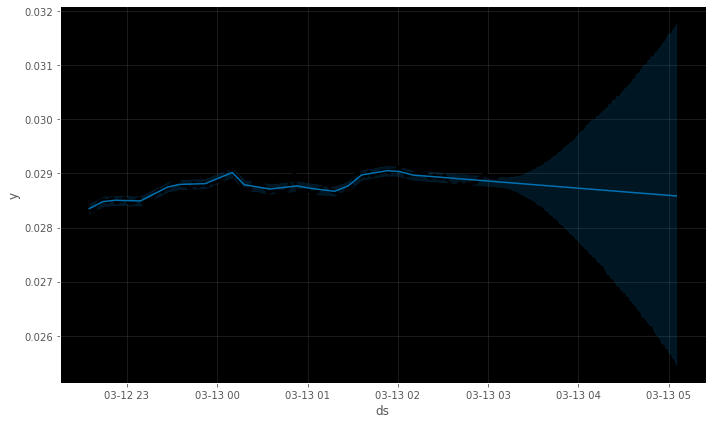

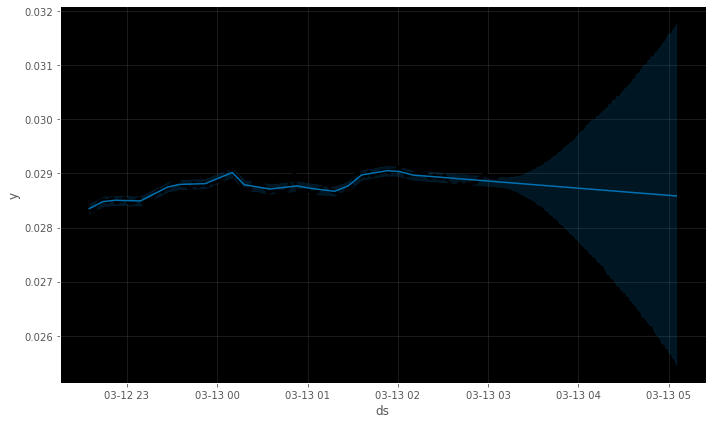

In [69]:
model.plot(forecast)

In [77]:
#Данный способ, при помощи библиотеки Prophet не показывает приемлемого результата

In [11]:
# Посчитаем межквартильный размах и его влияние на алерты

_1000BONKUSDT_pivort = pd.pivot_table(df, 
                                     values='Time_alert',
                                     index='batch',
                                     aggfunc='max')
yes=0
no=0
for i in tqdm(range(0,7346)):
    data_s = df[(df['batch']==i)]
    _1000BONKUSDT_iqr = data_s['Volume'].quantile(0.75) - data_s['Volume'].quantile(0.25)
    _1000BONKUSDT_upper_bound = (data_s['Volume'].quantile(0.75) + 1.5 * _1000BONKUSDT_iqr).astype('float32')

    # Посмотрим есть ли у токена выбросы
    _1000BONKUSDT_outliers = data_s[data_s['Volume'] > _1000BONKUSDT_upper_bound]

    # Посмотрим есть ли точка алерта в выбросах
    booler = str(_1000BONKUSDT_pivort.loc[i].values[0]) in [str(i) for i in _1000BONKUSDT_outliers['ds'].values]
    if booler==True:
        yes+=1
    else:
        no+=1

100%|█████████████████████████████████████████████████████████████████████████████| 7346/7346 [00:26<00:00, 277.09it/s]


In [12]:
yes, no

(6759, 587)

In [13]:
# исходя из полученного опыта можно говорить, что Вырос значения объемов торгов является сигналом для начала алерта

In [14]:
_1000BONKUSDT_pivort = pd.pivot_table(df, 
                                     values='Time_alert',
                                     index='batch',
                                     aggfunc='max')
yes=0
no=0
for i in tqdm(range(0,7346)):
    data_s = df[(df['batch']==i)]
    _1000BONKUSDT_iqr = data_s['High'].quantile(0.75) - data_s['High'].quantile(0.25)
    _1000BONKUSDT_upper_bound = (data_s['High'].quantile(0.75) + 1.5 * _1000BONKUSDT_iqr).astype('float32')

    # Посмотрим есть ли у токена выбросы
    _1000BONKUSDT_outliers = data_s[data_s['High'] > _1000BONKUSDT_upper_bound]

    # Посмотрим есть ли точка алерта в выбросах
    booler = str(_1000BONKUSDT_pivort.loc[i].values[0]) in [str(i) for i in _1000BONKUSDT_outliers['ds'].values]
    if booler==True:
        yes+=1
    else:
        no+=1
print(f'влияние выбросов по High на аллерт: {yes, no}')

100%|█████████████████████████████████████████████████████████████████████████████| 7346/7346 [00:26<00:00, 277.18it/s]

влияние выбросов по High на аллерт: (335, 7011)


In [15]:
_1000BONKUSDT_pivort = pd.pivot_table(df, 
                                     values='Time_alert',
                                     index='batch',
                                     aggfunc='max')
yes=0
no=0
for i in tqdm(range(0,7346)):
    data_s = df[(df['batch']==i)]
    _1000BONKUSDT_iqr = data_s['Low'].quantile(0.75) - data_s['Low'].quantile(0.25)
    _1000BONKUSDT_upper_bound = (data_s['Low'].quantile(0.75) + 1.5 * _1000BONKUSDT_iqr).astype('float32')

    # Посмотрим есть ли у токена выбросы
    _1000BONKUSDT_outliers = data_s[data_s['Low'] > _1000BONKUSDT_upper_bound]

    # Посмотрим есть ли точка алерта в выбросах
    booler = str(_1000BONKUSDT_pivort.loc[i].values[0]) in [str(i) for i in _1000BONKUSDT_outliers['ds'].values]
    if booler==True:
        yes+=1
    else:
        no+=1
print(f'влияние выбросов по Low на аллерт: {yes, no}')

100%|█████████████████████████████████████████████████████████████████████████████| 7346/7346 [00:26<00:00, 278.27it/s]

влияние выбросов по Low на аллерт: (29, 7317)


In [16]:
_1000BONKUSDT_pivort = pd.pivot_table(df, 
                                     values='Time_alert',
                                     index='batch',
                                     aggfunc='max')
yes=0
no=0
for i in tqdm(range(0,7346)):
    data_s = df[(df['batch']==i)]
    _1000BONKUSDT_iqr = data_s['Quote asset volume'].quantile(0.75) - data_s['Quote asset volume'].quantile(0.25)
    _1000BONKUSDT_upper_bound = (data_s['Quote asset volume'].quantile(0.75) + 1.5 * _1000BONKUSDT_iqr).astype('float32')

    # Посмотрим есть ли у токена выбросы
    _1000BONKUSDT_outliers = data_s[data_s['Quote asset volume'] > _1000BONKUSDT_upper_bound]

    # Посмотрим есть ли точка алерта в выбросах
    booler = str(_1000BONKUSDT_pivort.loc[i].values[0]) in [str(i) for i in _1000BONKUSDT_outliers['ds'].values]
    if booler==True:
        yes+=1
    else:
        no+=1
print(f'влияние выбросов по Low на аллерт: {yes, no}')

100%|█████████████████████████████████████████████████████████████████████████████| 7346/7346 [00:26<00:00, 277.47it/s]

влияние выбросов по Low на аллерт: (6741, 605)


In [17]:
_1000BONKUSDT_pivort = pd.pivot_table(df, 
                                     values='Time_alert',
                                     index='batch',
                                     aggfunc='max')
yes=0
no=0
for i in tqdm(range(0,7346)):
    data_s = df[(df['batch']==i)]
    _1000BONKUSDT_iqr = data_s['Number of trades'].quantile(0.75) - data_s['Number of trades'].quantile(0.25)
    _1000BONKUSDT_upper_bound = (data_s['Number of trades'].quantile(0.75) + 1.5 * _1000BONKUSDT_iqr).astype('float32')

    # Посмотрим есть ли у токена выбросы
    _1000BONKUSDT_outliers = data_s[data_s['Number of trades'] > _1000BONKUSDT_upper_bound]

    # Посмотрим есть ли точка алерта в выбросах
    booler = str(_1000BONKUSDT_pivort.loc[i].values[0]) in [str(i) for i in _1000BONKUSDT_outliers['ds'].values]
    if booler==True:
        yes+=1
    else:
        no+=1
print(f'влияние выбросов по Number of trades на аллерт: {yes, no}')

100%|█████████████████████████████████████████████████████████████████████████████| 7346/7346 [00:26<00:00, 274.97it/s]

влияние выбросов по Number of trades на аллерт: (6317, 1029)


In [18]:
_1000BONKUSDT_pivort = pd.pivot_table(df, 
                                     values='Time_alert',
                                     index='batch',
                                     aggfunc='max')
yes=0
no=0
for i in tqdm(range(0,7346)):
    data_s = df[(df['batch']==i)]
    _1000BONKUSDT_iqr = data_s['Taker buy base asset volume'].quantile(0.75) - data_s['Taker buy base asset volume'].quantile(0.25)
    _1000BONKUSDT_upper_bound = (data_s['Taker buy base asset volume'].quantile(0.75) + 1.5 * _1000BONKUSDT_iqr).astype('float32')

    # Посмотрим есть ли у токена выбросы
    _1000BONKUSDT_outliers = data_s[data_s['Taker buy base asset volume'] > _1000BONKUSDT_upper_bound]

    # Посмотрим есть ли точка алерта в выбросах
    booler = str(_1000BONKUSDT_pivort.loc[i].values[0]) in [str(i) for i in _1000BONKUSDT_outliers['ds'].values]
    if booler==True:
        yes+=1
    else:
        no+=1
print(f'влияние выбросов по Taker buy base asset volume на аллерт: {yes, no}')

100%|█████████████████████████████████████████████████████████████████████████████| 7346/7346 [00:26<00:00, 280.94it/s]

влияние выбросов по Taker buy base asset volume на аллерт: (7021, 325)


In [19]:
_1000BONKUSDT_pivort = pd.pivot_table(df, 
                                     values='Time_alert',
                                     index='batch',
                                     aggfunc='max')
yes=0
no=0
for i in tqdm(range(0,7346)):
    data_s = df[(df['batch']==i)]
    _1000BONKUSDT_iqr = data_s['Price_Change'].quantile(0.75) - data_s['Price_Change'].quantile(0.25)
    _1000BONKUSDT_upper_bound = (data_s['Price_Change'].quantile(0.75) + 1.5 * _1000BONKUSDT_iqr).astype('float32')

    # Посмотрим есть ли у токена выбросы
    _1000BONKUSDT_outliers = data_s[data_s['Price_Change'] > _1000BONKUSDT_upper_bound]

    # Посмотрим есть ли точка алерта в выбросах
    booler = str(_1000BONKUSDT_pivort.loc[i].values[0]) in [str(i) for i in _1000BONKUSDT_outliers['ds'].values]
    if booler==True:
        yes+=1
    else:
        no+=1
print(f'влияние выбросов по Price_Change на аллерт: {yes, no}')

100%|█████████████████████████████████████████████████████████████████████████████| 7346/7346 [00:26<00:00, 280.35it/s]

влияние выбросов по Price_Change на аллерт: (18, 7328)


In [20]:
# Исхдя из проделанного опята можно заключить, что период всплеска показателей Taker buy base asset!!! особенно Number of trades Quote asset volume, Volume 
# Является сигналом для начала алерта

In [21]:
# Для дополнительных измерений я дополню данные показателями технического анализа: MACD, Среднеквадратичное отклонение, Линии Болинжера, RSE

In [67]:
#df = df.drop(new_features,axis=1)
period = 10
for i in tqdm(df['batch'].unique()):
    df.loc[df['batch']==i, ["MACD"]] = df.loc[df['batch']==i]["Close"].rolling(period).mean()
    df.loc[df['batch']==i, ["Standard Deviation"]] = df.loc[df['batch']==i]["Close"].rolling(period).std()
    df.loc[df['batch']==i, ["Upper Bolinger Band"]] = df.loc[df['batch']==i]["MACD"] + (2 * df["Standard Deviation"])
    df.loc[df['batch']==i, ["Lower Bolinger Band"]] = df.loc[df['batch']==i]["MACD"] - (2 * df["Standard Deviation"])
    df.loc[df['batch']==i, ["Close Delta"]] = df.loc[df['batch']==i]["Close"].diff()
    df.loc[df['batch']==i, ["Gain"]] = df.loc[df['batch']==i]["Close Delta"].apply(lambda x:gain(x))
    df.loc[df['batch']==i, ["Loss"]] = df.loc[df['batch']==i]["Close Delta"].apply(lambda x:loss(x))

    #Calculate ema 
    df.loc[df['batch']==i, ["EMA Gain"]] = df.loc[df['batch']==i]["Gain"].ewm(period).mean()
    df.loc[df['batch']==i, ["EMA Loss"]] = df.loc[df['batch']==i]["Loss"].ewm(period).mean()

    #Calculate RSI
    df.loc[df['batch']==i, ["Relative Strength"]] = df.loc[df['batch']==i]["EMA Gain"]/df["EMA Loss"]
    df.loc[df['batch']==i, ['RSI']] = df.loc[df['batch']==i]['Relative Strength'].apply(lambda x: 100 - (100/(x+1)))

    df.loc[df['batch']==i, ['Daily_Return']] = df.loc[df['batch']==i]['Close'].pct_change()

100%|██████████████████████████████████████████████████████████████████████████████| 7346/7346 [46:47<00:00,  2.62it/s]


In [68]:
df

,ds,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Time_alert,Price_alert,batch,token,Price_Change,min_max_range,y,MACD,Standard Deviation,Upper Bolinger Band,Lower Bolinger Band,Close Delta,Gain,Loss,EMA Gain,EMA Loss,Relative Strength,RSI,Daily_Return
0,2024-03-12 22:35:00,0.028353,0.028359,0.028323,0.028343,1.731354e+06,2024-03-12 22:35:59.999,49064.449219,443,4.197650e+05,2024-03-13 00:04:00,0.029114,0,1000BONKUSDT,0.000010,0.000036,0.028348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-03-12 22:36:00,0.028342,0.028354,0.028275,0.028319,4.202372e+06,2024-03-12 22:36:59.999,118950.156250,737,1.497496e+06,2024-03-13 00:04:00,0.029114,0,1000BONKUSDT,0.000023,0.000079,0.028330,NaN,NaN,NaN,NaN,-0.000024,0.000000,0.000024,0.000000,0.000024,0.000000,0.000000,-0.000847
2,2024-03-12 22:37:00,0.028319,0.028342,0.028305,0.028333,1.677868e+06,2024-03-12 22:37:59.999,47526.148438,398,9.582670e+05,2024-03-13 00:04:00,0.029114,0,1000BONKUSDT,-0.000014,0.000037,0.028326,NaN,NaN,NaN,NaN,0.000014,0.000014,0.000000,0.000007,0.000011,0.641731,39.088670,0.000494
3,2024-03-12 22:38:00,0.028334,0.028349,0.028319,0.028336,1.428227e+06,2024-03-12 22:38:59.999,40467.351562,307,8.427180e+05,2024-03-13 00:04:00,0.029114,0,1000BONKUSDT,-0.000002,0.000030,0.028335,NaN,NaN,NaN,NaN,0.000003,0.000003,0.000000,0.000006,0.000007,0.792922,44.225125,0.000106
4,2024-03-12 22:39:00,0.028333,0.028403,0.028333,0.028382,3.360009e+06,2024-03-12 22:39:59.999,95359.367188,545,1.774116e+06,2024-03-13 00:04:00,0.029114,0,1000BONKUSDT,-0.000049,0.000070,0.028358,NaN,NaN,NaN,NaN,0.000046,0.000046,0.000000,0.000017,0.000005,3.343980,76.979634,0.001623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990761,2024-04-02 02:58:00,0.689800,0.690000,0.686700,0.687400,2.216839e+05,2024-04-02 02:58:59.999,152591.500000,710,8.560630e+04,2024-04-02 00:02:00,0.712900,7345,ZRXUSDT,0.002400,0.003300,0.688600,0.68737,0.002069,0.691509,0.683231,-0.002300,0.000000,0.002300,0.001215,0.001326,0.915870,47.804385,-0.003335
1990762,2024-04-02 02:59:00,0.687400,0.688000,0.686700,0.687200,1.764899e+05,2024-04-02 02:59:59.999,121327.484375,633,9.726340e+04,2024-04-02 00:02:00,0.712900,7345,ZRXUSDT,0.000200,0.001300,0.687300,0.68733,0.002068,0.691467,0.683193,-0.000200,0.000000,0.000200,0.001104,0.001224,0.902264,47.431069,-0.000291
1990763,2024-04-02 03:00:00,0.687200,0.689900,0.686700,0.689800,3.126888e+05,2024-04-02 03:00:59.999,215123.703125,1120,2.141299e+05,2024-04-02 00:02:00,0.712900,7345,ZRXUSDT,-0.002600,0.003200,0.688500,0.68754,0.002212,0.691963,0.683117,0.002600,0.002600,0.000000,0.001240,0.001113,1.114724,52.712502,0.003783
1990764,2024-04-02 03:01:00,0.689700,0.693300,0.688500,0.692900,3.684429e+05,2024-04-02 03:01:59.999,254735.437500,1090,2.192688e+05,2024-04-02 00:02:00,0.712900,7345,ZRXUSDT,-0.003200,0.004800,0.691300,0.68788,0.002744,0.693368,0.682392,0.003100,0.003100,0.000000,0.001409,0.001011,1.393369,58.217897,0.004494


In [23]:
new_features = df.columns[17:].values

In [24]:
new_features

array(['MACD', 'Standard Deviation', 'Upper Bolinger Band',
       'Lower Bolinger Band', 'Close Delta', 'Gain', 'Loss', 'EMA Gain',
       'EMA Loss', 'Relative Strength', 'RSI', 'Daily_Return'],
      dtype=object)

In [69]:
_1000BONKUSDT_pivort = pd.pivot_table(df, 
                                     values='Time_alert',
                                     index='batch',
                                     aggfunc='max')

for track in tqdm(new_features):
    yes=0
    no=0
    for i in range(0,7346):
        data_s = df[(df['batch']==i)]
        _1000BONKUSDT_iqr = data_s[track].quantile(0.75) - data_s[track].quantile(0.25)
        _1000BONKUSDT_upper_bound = (data_s[track].quantile(0.75) + 1.5 * _1000BONKUSDT_iqr).astype('float32')

        # Посмотрим есть ли у токена выбросы
        _1000BONKUSDT_outliers = data_s[data_s[track] > _1000BONKUSDT_upper_bound]

        # Посмотрим есть ли точка алерта в выбросах
        booler = str(_1000BONKUSDT_pivort.loc[i].values[0]) in [str(i) for i in _1000BONKUSDT_outliers['ds'].values]
        if booler==True:
            yes+=1
        else:
            no+=1
    print(f'влияние выбросов по {track} на аллерт: {yes, no}')

  8%|██████▉                                                                            | 1/12 [00:25<04:44, 25.82s/it]

влияние выбросов по MACD на аллерт: (9, 7337)


 17%|█████████████▊                                                                     | 2/12 [00:51<04:16, 25.69s/it]

влияние выбросов по Standard Deviation на аллерт: (1123, 6223)


 25%|████████████████████▊                                                              | 3/12 [01:16<03:50, 25.62s/it]

влияние выбросов по Upper Bolinger Band на аллерт: (55, 7291)


 33%|███████████████████████████▋                                                       | 4/12 [01:42<03:24, 25.56s/it]

влияние выбросов по Lower Bolinger Band на аллерт: (9, 7337)


 42%|██████████████████████████████████▌                                                | 5/12 [02:07<02:58, 25.56s/it]

влияние выбросов по Close Delta на аллерт: (5840, 1506)


 50%|█████████████████████████████████████████▌                                         | 6/12 [02:33<02:33, 25.58s/it]

влияние выбросов по Gain на аллерт: (6858, 488)


 58%|████████████████████████████████████████████████▍                                  | 7/12 [02:59<02:07, 25.60s/it]

влияние выбросов по Loss на аллерт: (38, 7308)


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [03:24<01:42, 25.59s/it]

влияние выбросов по EMA Gain на аллерт: (2378, 4968)


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [03:50<01:16, 25.56s/it]

влияние выбросов по EMA Loss на аллерт: (14, 7332)


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [04:15<00:51, 25.59s/it]

влияние выбросов по Relative Strength на аллерт: (3774, 3572)


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [04:41<00:25, 25.62s/it]

влияние выбросов по RSI на аллерт: (536, 6810)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [05:07<00:00, 25.59s/it]

влияние выбросов по Daily_Return на аллерт: (5849, 1497)


In [ ]:
features = ['High', 'Gain', 'Taker buy base asset volume', 'Number of trades']
for i in df['token'].unique()[:20]:
    mask = np.triu(np.ones_like(df[df['token']==i][features].corr()))
    plt.figure(figsize=(18,12))
    plt.title(f'Корреляция существенных для алерта признаков по токену: {i}')
    sns.heatmap(df[df['token']==i][features].corr(), annot=True, mask=mask, cmap='crest')
    plt.show()

In [27]:
#По опыту можно сделать вывод, что по при выбросе показателя дельты происходит алерт т.е. все сходится на том, что алерт происходит при нетипичной ситуации на рыке, т.к. gain произростает от
# норамльности или ненормальности данных, следовательно при совпадении показателей Taker buy base asset особенно ,Number of trades, Quote asset volume, Volume, Gain , Close Delta
# происходит импульс, который дает сигнал на вход в сделку

In [9]:
# По признакам 'High', 'Gain', 'Taker buy base asset volume', 'Number of trades' я будуу использовать только один из этих признаков
# при построении стратегии, т.к. фичи достаточно зависимы друг от друга

In [70]:
tocken_volatility = np.zeros_like(df['Daily_Return'])
period = 10  # You can adjust this value based on your preference
for i in tqdm(range(0,7346)):
    tocken_volatility[df[df['batch']==i].index] = df.loc[df['batch']==i]['Daily_Return'].rolling(window=period).std()

100%|█████████████████████████████████████████████████████████████████████████████| 7346/7346 [00:30<00:00, 244.07it/s]


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], tocken_volatility, label='Tocken Volatility', color='orange')
plt.title('Volatility of Tocken Prices')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# В целом 

In [83]:
df.to_parquet(r'C:\Users\aleksandrovva1\Desktop\data science\crypto\all_df.pq')

In [78]:
reproc_ = df.select_dtypes(np.float64).columns

In [81]:
df[reproc_] = df[reproc_].astype(np.float32)

In [ ]:
for i in range(0,100): 
    plt.rcParams['axes.facecolor'] = 'white'
    fig, ax = plt.subplots(2,1, figsize=(24,11))
    #plt.subplot(2, 1, 2)
    ax[0].plot(df[df['batch']==i]['ds'], df[df['batch']==i]['High'], label=f'{i} Close', color='orange')
    ax[0].plot(df[df['batch']==i]['ds'], df[df['batch']==i]['Upper Bolinger Band'], color='blue')
    ax[0].plot(df[df['batch']==i]['ds'], df[df['batch']==i]['Lower Bolinger Band'], color='green')
    ax[1].plot(df[df['batch']==i]['ds'], df[df['batch']==i]['RSI'], color='red')
    ax[0].scatter(df[df['batch']==i]['Time_alert'], df[df['batch']==i]['Price_alert'], c='black')
    ax[0].plot(df[df['batch']==i]['ds'], df[df['batch']==i]['MACD'], label=f'{i} EMA ({period} days)', color='red')
    plt.title(f'Цены по токену {i} и метрики средних')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    print('**********'*10)

In [106]:
# Как можно наблюдать на графиках алерт происходит при пересечении верхней линии полосы болинжера, либо при ее соприкасании
# Также стоит отметить, что на алерты имее влияние сила тренда RSI, при достижении этого показателя больше 70 происходит аллерт
# стоит также отметить, что алерт наступает не сразу, а при повторном наступлении события пересечения верхней полосы болинжера 
# и всплеска показателя RSI, на графиках видна ситауция, когда алерт распологается зачастую выше средневсвешанной цены за минуту
# при этом полоса болинжера зачастую непересечена, это можно объяснить тем, что согласно событиям произошел кратковременный всплеск
# цены, когда она пересекала полосу, т.е. сигналом служит реское изменение цены

In [200]:
def trade_strategy(df, batch, trade_long_start, trade_short_start):
    sample = df[df['batch']==batch].reset_index().copy()
    
    # контейнеры для данных 
    entry_time = []
    exit_time = []
    trade_side = []
    bb_h_value = []
    bb_l_value = []
    rsi_value = []
    entry_price = []
    exit_price = []
    macd_value = []
    volume_value = []
    target_price = []
    stop_price = []

    # временные переменные
    trade_taken = False
    target = 0
    stop = 0

    for index,datetime in zip(sample.index, sample['ds']):
        # переменные по данным 
        current_datetime = datetime
        rsi = sample.iloc[index]["RSI"]
        medium = sample.iloc[index]['High']
        macd = sample.iloc[index]['MACD']
        volume = sample.iloc[index]['Volume']
        upper_bolinger = sample.iloc[index]['Upper Bolinger Band']
        lower_bolinger = sample.iloc[index]['Lower Bolinger Band']
        
        volume_iqr = sample['Volume'].quantile(0.75) - sample['Volume'].quantile(0.25)
        volume_upper_bound = (sample['Volume'].quantile(0.75) + 1.5 * volume_iqr).astype('float32')
        
        # Выбираем те сигналя, по которым динамика RSI наиболее благоприятна 
        if ((rsi > trade_long_start) and (rsi < trade_short_start) and (trade_taken == False) and (volume >= volume_upper_bound)):
            continue
        # проверяю наличие новой шортового сигнала    
        elif ((rsi <= trade_short_start) and (trade_taken == False) and (lower_bolinger <= medium) and (macd >= medium)  and (index != sample.shape[0]-1)):#(macd <= medium)
            trade_taken = "short_entered"
            short_target = medium*0.98
            short_stop = medium*1.025
            
            entry_time.append(current_datetime)
            rsi_value.append(rsi)
            macd_value.append(macd)
            volume_value.append(volume)
            bb_h_value.append(upper_bolinger)
            bb_l_value.append(lower_bolinger)
            trade_side.append("short")
            entry_price.append(medium)
            target_price.append(short_target)
            stop_price.append(short_stop)

        # просмотр цены на предмет выхода из сделки      
        elif (trade_taken == "short_entered") and (medium > short_stop):

            trade_taken = False
            exit_time.append(current_datetime) 
            exit_price.append(medium)

        # просмотр цены на предмет выхода из сделки
        elif (trade_taken == "short_entered") and (medium < short_target):

            trade_taken = False
            exit_time.append(current_datetime) 
            exit_price.append(medium)
            
            
        #Поиск возможностей для лонга
        elif ((rsi >= trade_long_start) and (trade_taken == False) and (upper_bolinger >= medium) and (macd <= medium) and (index != sample.shape[0]-1)): #and (macd >= medium)
            trade_taken = "long_entered"
            long_target = medium*1.02
            long_stop = medium*0.975

            entry_time.append(current_datetime)
            rsi_value.append(rsi)
            macd_value.append(macd)
            volume_value.append(volume)
            bb_h_value.append(upper_bolinger)
            bb_l_value.append(lower_bolinger)
            trade_side.append("long")
            entry_price.append(medium)
            target_price.append(long_target)
            stop_price.append(long_stop)

        elif (trade_taken == "long_entered") and (medium < long_stop):

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(medium)
        
            
        elif (trade_taken == "long_entered") and (medium > long_target):

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(medium)
            

        # (Код для сбережения денег) если при последнем вводе данных мы все еще удерживаем сделку, то отменяем сделку
        elif (index == (len(sample) - 1)) and (trade_taken != False):

            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(medium)  
    #print(len(entry_time), len(exit_time), len(rsi_value), len(bb_h_value), len(bb_l_value), len(macd_value), len(volume_value), len(trade_side), len(entry_price), len(target_price), len(stop_price))
    trade_sheet = pd.DataFrame({
                                "BATCH":batch,
                               "token_name":sample['token'].unique()[0],
                               "entry_time":entry_time,
                               "exit_time":exit_time,
                               "rsi_value":rsi_value,
                               "bb_h_value":bb_h_value,
                               "bb_l_value":bb_l_value,
                               "macd_value": macd_value,
                               "volume_value": volume_value,
                               "trade_side":trade_side,
                               "entry_price":entry_price,
                               "exit_price":exit_price,
                               "target_price":target_price,
                               "stop_price":stop_price})

    # расчет возможной прибыли
    trade_sheet["pnl"] = 0

    short_deal = trade_sheet['trade_side'] == "short"
    long_deal = trade_sheet['trade_side'] == "long"
    trade_sheet.loc[short_deal,"pnl"] = trade_sheet.loc[short_deal,"entry_price"] - trade_sheet.loc[short_deal,"exit_price"]
    trade_sheet.loc[long_deal,"pnl"] = trade_sheet.loc[long_deal,"exit_price"] - trade_sheet.loc[long_deal,"entry_price"]
    return trade_sheet

In [201]:
all_dfff = pd.DataFrame()
for i in tqdm(range(0,7346)):
    sheet = trade_strategy(df, i, 20, 80)
    all_dfff = pd.concat([all_dfff, sheet])

100%|██████████████████████████████████████████████████████████████████████████████| 7346/7346 [46:12<00:00,  2.65it/s]


In [10]:
# Скрипт для проверки сигналов по стратегии торговли

KeyError: 'BATCH'

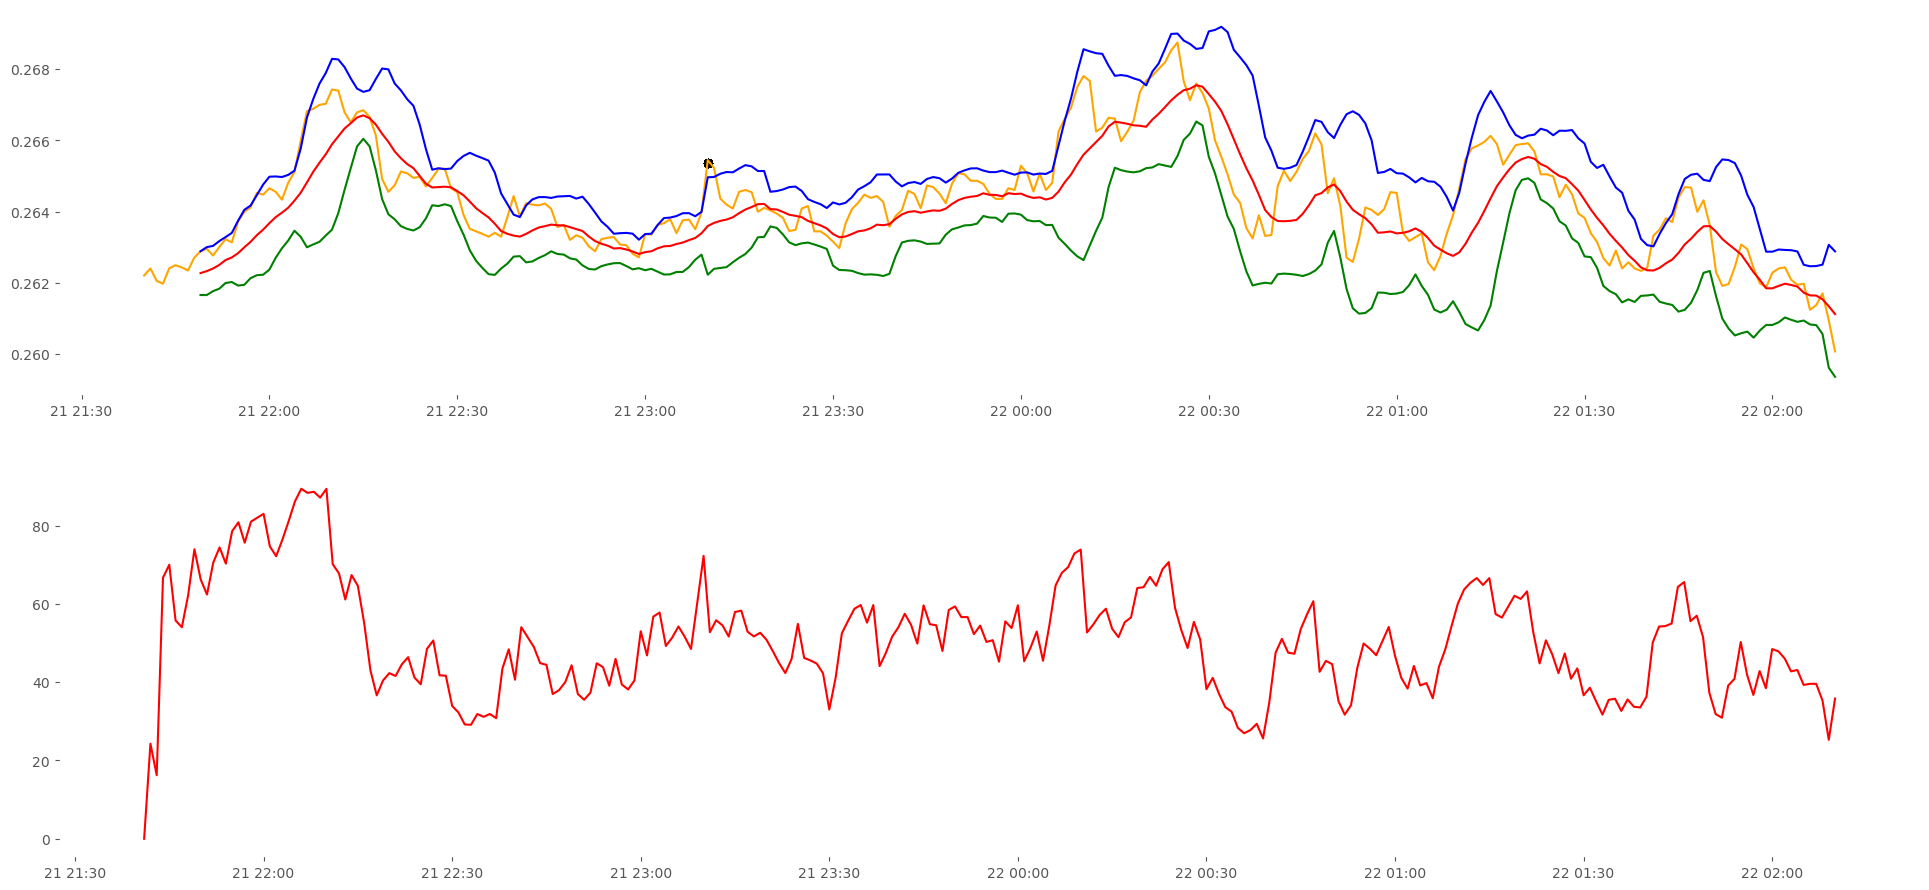

In [185]:
period = 10
for i in range(130,132): 
    plt.rcParams['axes.facecolor'] = 'white'
    fig, ax = plt.subplots(2,1, figsize=(24,11))
    #plt.subplot(2, 1, 2)
    ax[0].plot(df[df['batch']==i]['ds'], df[df['batch']==i]['High'], label=f'{i} Close', color='orange')
    ax[0].plot(df[df['batch']==i]['ds'], df[df['batch']==i]['Upper Bolinger Band'], color='blue')
    ax[0].plot(df[df['batch']==i]['ds'], df[df['batch']==i]['Lower Bolinger Band'], color='green')
    ax[1].plot(df[df['batch']==i]['ds'], df[df['batch']==i]['RSI'], color='red')
    ax[0].scatter(df[df['batch']==i]['Time_alert'], df[df['batch']==i]['Price_alert'], c='black')
    ax[0].plot(df[df['batch']==i]['ds'], df[df['batch']==i]['MACD'], label=f'{i} EMA ({period} days)', color='red')
    ax[0].scatter(all_dfff[all_dfff['BATCH']==i]['entry_time'], all_dfff[all_dfff['BATCH']==i]['entry_price'], label=f'{i} EMA ({period} days)', marker='v', color='green', s=100)
    ax[0].scatter(all_dfff[all_dfff['BATCH']==i]['exit_time'], all_dfff[all_dfff['BATCH']==i]['exit_price'], label=f'{i} EMA ({period} days)', marker='^', color='red', s=100)
    plt.title(f'Цены по токену {i} и метрики средних')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    print('**********'*10)

In [203]:
all_dfff.reset_index().to_parquet(r'G:\data_scence\crypto_search\signals.pq', index=False)

In [11]:
signals = pd.read_parquet(PATH+ '\signals.pq')

In [17]:
sum(signals['pnl'])

1977.949409083405

In [14]:
len(signals[signals['pnl']>0]), len(signals[signals['pnl']<0])

(12964, 10745)

In [206]:
#По этим сигналам потенциально можно получить прибыль

In [18]:
# Попробую предсказать будущую цену токена при помощи модели ARIMA из библиотеки statsmodels

In [6]:
features = [i for i in df.columns if i not in ['Time_alert','Price_alert','batch', 'token', 'Close time']]

In [5]:
data_for_armina = df[df['batch']==0][['ds','Open']].dropna().set_index('ds')

In [6]:
train_size = int(len(data_for_armina) * 0.75)
train, test = data_for_armina.iloc[:train_size], data_for_armina.iloc[train_size:]

In [7]:
study = optuna.create_study(study_name='Поиск параметров для ARIMA', direction='minimize')

In [8]:
def objective(trial):   
    
    p = trial.suggest_int('p', 0, 8)
    d = trial.suggest_int('d', 0, 8)
    q = trial.suggest_int('q', 0, 8)
    P = trial.suggest_int('P', 0, 12)
    D = trial.suggest_int('D', 0, 12)
    Q = trial.suggest_int('Q', 0, 12)
    
    model = ARIMA(train,
                  order=(p, d, q), 
                  seasonal_order=(P, D, Q, 60),
                  enforce_stationarity=False
                 ).fit()
    
    pred = model.forecast(steps=len(test))
    error = mean_squared_error(test, pred)
    
    return error

In [ ]:
study.optimize(objective, n_trials=200, show_progress_bar=True, n_jobs=-1)

  0%|          | 0/200 [00:00<?, ?it/s]

In [18]:
study.best_params

{'p': 6, 'd': 0, 'q': 6}

In [16]:
print(f'{study.best_value:.20f}')

0.00000000927436471205


In [9]:
model = ARIMA(
    train,
    order=(3,0,8)).fit()
pred = model.forecast(steps=len(test))

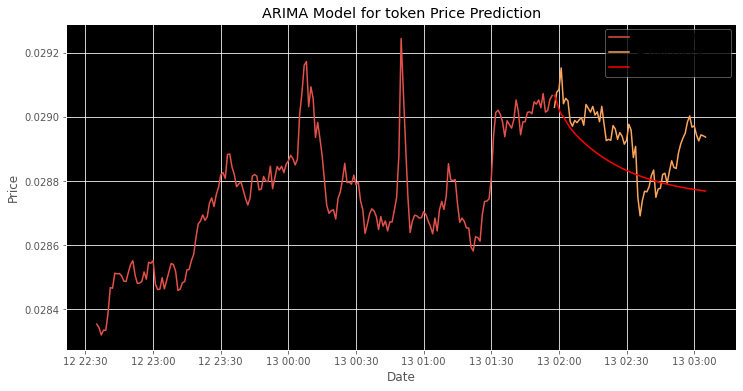

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Prices')
plt.plot(test.index, pred, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model for token Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [12]:
# Не очень многообещающий результат, попробую LSTM

In [17]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_for_armina)

# Prepare the data for LSTM
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:(i+time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

time_steps = 10
x, y = create_dataset(scaled_data, time_steps)


train_size = int(len(X) * 0.8)
train_x, test_x = x[:train_size], x[train_size:]
train_y, test_y = y[:train_size], y[train_size:]


train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (testX.shape[0], 1, test_x.shape[1]))


model = Sequential()
model.add(LSTM(50, input_shape=(1, time_steps), activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(train_x, train_y, epochs=100, batch_size=32, verbose=0)


predictions = model.predict(test_x)
predictions = scaler.inverse_transform(predictions)


actual_values = scaler.inverse_transform([test_y])


mse = mean_squared_error(actual_values[0], predictions[:, 0])
print(f'Mean Squared Error: {mse}')

NameError: name 'X' is not defined

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data_for_armina.index[train_size+time_steps:], actual_values[0], label='Actual Prices')
plt.plot(data_for_armina.index[train_size+time_steps:], predictions[:, 0], label='LSTM Predictions', color='red')
plt.title('LSTM Model for token Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()